In [1]:
import itertools
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import seaborn as sns
import sqlite3

In [2]:
cc = itertools.cycle(sns.color_palette('colorblind'))
color_map = {
    "simple_cnn": next(cc),
    "resnet": next(cc),
    "resnet_pretrained": next(cc),
    "resnet_pretrained_embeddings": next(cc),
    "resnet_no_pool": next(cc),
    "unseen": next(cc),
    "geo_mean_seen": next(cc),
    "geo_mean_unseen": next(cc)
}
model_name_map = {
    "simple_cnn": "2-Layer CNN",
    "resnet": "ResNet-18",
    "resnet_pretrained": "ResNet-18 (CIFAR-10 Pretrained)",
    "resnet_pretrained_embeddings": "ResNet-18 (CIFAR-10 Embeddings)",
    "resnet_no_pool": "ResNet-18 (Avg. Pooling Layer Removed)",
}

In [3]:
def get_timestamps(input_name, model_name, output_name, experiment_name):
    conn = sqlite3.connect('../results/results_lookup.db')
    c = conn.cursor()
    timestamps = []
    for row in c.execute('''
        SELECT * FROM experiments 
            WHERE input=?
                AND output=?
                AND model=?
                AND experiment=?
                AND timestamp>'2020-01-21_00:00:00_000000'
    ''', (input_name, output_name, model_name, experiment_name)):
        timestamps.append(row[0])
#     print(str(len(timestamps)) + " experiment entries found")
    return timestamps[-30:]

In [4]:
def get_results(timestamps):
    train_results, test_results = [], []
    for trial_timestamp in timestamps:
        try:
            with open('../results/' + trial_timestamp + "/train.json") as train_fp:
                train_results.append(json.load(train_fp))
            with open('../results/' + trial_timestamp + "/test.json") as test_fp:
                test_results.append(json.load(test_fp))
        except:
            pass
    print(len(test_results))
    return train_results, test_results
   
def get_keep_pcts(test_results):
    return sorted(list(test_results[0].keys()))[::-1]

def get_label_names(test_results, keep_pcts):
    if "class_3_name" not in test_results[0][keep_pcts[0]][0]:
        return test_results[0][keep_pcts[0]][0]["class_1_name"].capitalize(), \
               test_results[0][keep_pcts[0]][0]["class_2_name"].capitalize()
    else:
        return test_results[0][keep_pcts[0]][0]["class_1_name"].capitalize(), \
               test_results[0][keep_pcts[0]][0]["class_2_name"].capitalize(), \
               test_results[0][keep_pcts[0]][0]["class_3_name"].capitalize(), \
               test_results[0][keep_pcts[0]][0]["class_4_name"].capitalize()

In [5]:
def get_left_out_accs(test_results, keep_pcts):
    left_out_final_num_accs_raw = np.array([[trial_test_results[keep_pct][-1]["left_out_num_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    left_out_final_num_accs = np.mean(left_out_final_num_accs_raw, axis=0)
    left_out_final_num_accs_std = np.std(left_out_final_num_accs_raw, axis=0)
    left_out_final_col_accs_raw = np.array([[trial_test_results[keep_pct][-1]["left_out_col_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    left_out_final_col_accs = np.mean(left_out_final_col_accs_raw, axis=0)
    left_out_final_col_accs_std = np.std(left_out_final_col_accs_raw, axis=0)
    left_out_final_loc_accs_raw = np.array([[trial_test_results[keep_pct][-1]["left_out_loc_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    left_out_final_loc_accs = np.mean(left_out_final_loc_accs_raw, axis=0)
    left_out_final_loc_accs_std = np.std(left_out_final_loc_accs_raw, axis=0)
    left_out_final_scale_accs_raw = np.array([[trial_test_results[keep_pct][-1]["left_out_scale_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    left_out_final_scale_accs = np.mean(left_out_final_scale_accs_raw, axis=0)
    left_out_final_scale_accs_std = np.std(left_out_final_scale_accs_raw, axis=0)
    return (left_out_final_num_accs, left_out_final_num_accs_std), \
           (left_out_final_col_accs, left_out_final_col_accs_std), \
           (left_out_final_loc_accs, left_out_final_loc_accs_std), \
           (left_out_final_scale_accs, left_out_final_scale_accs_std) 

def get_non_left_out_accs(test_results, keep_pcts):
    non_left_out_final_num_accs_raw = np.array([[trial_test_results[keep_pct][-1]["non_left_out_num_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    non_left_out_final_num_accs = np.mean(non_left_out_final_num_accs_raw, axis=0)
    non_left_out_final_num_accs_std = np.std(non_left_out_final_num_accs_raw, axis=0)
    non_left_out_final_col_accs_raw = np.array([[trial_test_results[keep_pct][-1]["non_left_out_col_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    non_left_out_final_col_accs = np.mean(non_left_out_final_col_accs_raw, axis=0)
    non_left_out_final_col_accs_std = np.std(non_left_out_final_col_accs_raw, axis=0)
    non_left_out_final_loc_accs_raw = np.array([[trial_test_results[keep_pct][-1]["non_left_out_loc_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    non_left_out_final_loc_accs = np.mean(non_left_out_final_loc_accs_raw, axis=0)
    non_left_out_final_loc_accs_std = np.std(non_left_out_final_loc_accs_raw, axis=0)
    non_left_out_final_scale_accs_raw = np.array([[trial_test_results[keep_pct][-1]["non_left_out_scale_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    non_left_out_final_scale_accs = np.mean(non_left_out_final_scale_accs_raw, axis=0)
    non_left_out_final_scale_accs_std = np.std(non_left_out_final_scale_accs_raw, axis=0)
    return (non_left_out_final_num_accs, non_left_out_final_num_accs_std), \
           (non_left_out_final_col_accs, non_left_out_final_col_accs_std), \
           (non_left_out_final_loc_accs, non_left_out_final_loc_accs_std), \
           (non_left_out_final_scale_accs, non_left_out_final_scale_accs_std) 

In [6]:
def get_directory(input_name, model_name, output_name, experiment_name):
    directory = "../plots/{}/{}/{}/{}/".format(experiment_name, output_name, input_name, model_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

def plot(keep_pcts, label_names, left_out_accs, non_left_out_accs, directory, model_name):   
    sns.set()
    sns.set_style('ticks')
    sns.set_context("poster")
    
    for i in range(len(label_names)):
        label_name = label_names[i]
        left_out_final_accs, left_out_final_accs_std = left_out_accs[i]
        non_left_out_final_accs, non_left_out_final_accs_std = non_left_out_accs[i]

        fig, ax = plt.subplots(figsize=(8, 6))
    
        ax.errorbar(keep_pcts[:0:-1], non_left_out_final_accs[:0:-1],
                    yerr=non_left_out_final_accs_std[:0:-1], zorder=10,
                    fmt='-s', clip_on=False, linewidth=4, ls='--', color=color_map[model_name])
        
        ax.errorbar(keep_pcts[:0:-1], left_out_final_accs[:0:-1], 
                    yerr=left_out_final_accs_std[:0:-1], zorder=10,
                    fmt='-o', clip_on=False, linewidth=4, color=color_map[model_name])
        
        ax.set_ylim(0, 1)
        ax.set_xlabel('Keep %')
        ax.set_ylabel('Test Accuracy')
        ax.set_title((r'Final Hold-Out $\bf {}$ Classification' + '\nAccuracy v. Keep %').format(label_name), fontsize=25, y=1.08)
        ax.legend(["Seen Combinations", "Unseen Combinations"], loc='best', fontsize=20, framealpha=1,)

        # Set minor tick locations.
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
        # Set grid to use minor tick locations. 
        ax.grid(which = 'both')
        plt.subplots_adjust(top=0.8, bottom=0.2, left=0.17)
        
        plt.xticks(keep_pcts[:0:-2], labels=[str(i + 1) + "/" + str(len(keep_pcts)) for i in range(0, len(keep_pcts), 2)])
        plt.yticks([x / 10. for x in range(0, 11, 2)])
        for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(20)
        fig.savefig(directory + "hold_out_{}_acc.pdf".format(label_name.lower()), dpi=500)
        plt.show()
        fig.clf()
        
def plot_geo_mean(keep_pcts, test_results, directory, model_name):
    sns.set()
    sns.set_style('ticks')
    sns.set_context("poster")

    left_out_final_num_accs_raw = np.array([[trial_test_results[keep_pct][-1]["left_out_num_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    left_out_final_col_accs_raw = np.array([[trial_test_results[keep_pct][-1]["left_out_col_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    left_out_final_loc_accs_raw = np.array([[trial_test_results[keep_pct][-1]["left_out_loc_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    left_out_final_scale_accs_raw = np.array([[trial_test_results[keep_pct][-1]["left_out_scale_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    
    non_left_out_final_num_accs_raw = np.array([[trial_test_results[keep_pct][-1]["non_left_out_num_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    non_left_out_final_col_accs_raw = np.array([[trial_test_results[keep_pct][-1]["non_left_out_col_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    non_left_out_final_loc_accs_raw = np.array([[trial_test_results[keep_pct][-1]["non_left_out_loc_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    non_left_out_final_scale_accs_raw = np.array([[trial_test_results[keep_pct][-1]["non_left_out_scale_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    
    left_out_geo_mean_acc_raw = np.sqrt(left_out_final_num_accs_raw * left_out_final_col_accs_raw * left_out_final_loc_accs_raw * left_out_final_scale_accs_raw)
    left_out_geo_mean_acc = np.mean(left_out_geo_mean_acc_raw, axis=0)
    left_out_geo_mean_acc_std = np.std(left_out_geo_mean_acc_raw, axis=0)
    
    non_left_out_geo_mean_acc_raw = np.sqrt(non_left_out_final_num_accs_raw * non_left_out_final_col_accs_raw * non_left_out_final_loc_accs_raw * non_left_out_final_scale_accs_raw)
    non_left_out_geo_mean_acc = np.mean(non_left_out_geo_mean_acc_raw, axis=0)
    non_left_out_geo_mean_acc_std = np.std(non_left_out_geo_mean_acc_raw, axis=0)

    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.errorbar(keep_pcts[:0:-1], non_left_out_geo_mean_acc[:0:-1],
                yerr=non_left_out_geo_mean_acc_std[:0:-1], zorder=10,
                fmt='-s', clip_on=False, linewidth=4, ls='--', color=color_map[model_name])
    
    ax.errorbar(keep_pcts[:0:-1], left_out_geo_mean_acc[:0:-1],
                yerr=left_out_geo_mean_acc_std[:0:-1], zorder=10,
                fmt='-o', clip_on=False, linewidth=4, color=color_map[model_name])
    
    ax.set_ylim(0, 1)
    ax.set_xlabel('Keep %')
    ax.set_ylabel('Test Accuracy')
    ax.set_title(r'$\bf{Geometric}$ $\bf{Mean}$ of' + '\nTest Accuracy v. Keep %', fontsize=25, y=1.08)
    ax.legend(["Seen Combinations", "Unseen Combinations"], loc='best', fontsize=20, framealpha=1,)
    
    # Set minor tick locations.
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    # Set grid to use minor tick locations. 
    ax.grid(which = 'both')

    plt.xticks(keep_pcts[:0:-2], labels=[str(i + 1) + "/" + str(len(keep_pcts)) for i in range(0, len(keep_pcts), 2)])
#     plt.yticks([y / 4. for y in range(0, 5)])
    plt.yticks([x / 10. for x in range(0, 11, 2)])
    for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    plt.subplots_adjust(top=0.8, bottom=0.2, left=0.17)

    fig.savefig(directory + "geo_mean_acc.pdf", dpi=500)
    plt.show()
    fig.clf()

In [7]:
def run_all(input_name, model_name, output_name, experiment_name):
    timestamps = get_timestamps(input_name, model_name, output_name, experiment_name)
    _, test_results = get_results(timestamps)
    keep_pcts = get_keep_pcts(test_results)
    label_names = get_label_names(test_results, keep_pcts)
    left_out_accs = get_left_out_accs(test_results, keep_pcts)
    non_left_out_accs = get_non_left_out_accs(test_results, keep_pcts)

    directory = get_directory(input_name, model_name, output_name, experiment_name)
    plot(keep_pcts, label_names, left_out_accs, non_left_out_accs, directory, model_name)
    plot_geo_mean(keep_pcts, test_results, directory, model_name)

In [8]:
input_name = "left_out_varied_location_mnist"
model_name = "resnet_no_pool"
output_name = "keep_pct_readout_dump"
experiment_name = "keep_pct_readout_9_class_weighted_save"

Task: col_loc_scale_mnist keep_pct_readout_4_task
Architecture: resnet
23


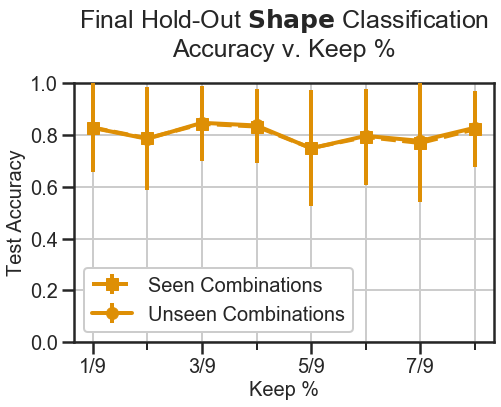

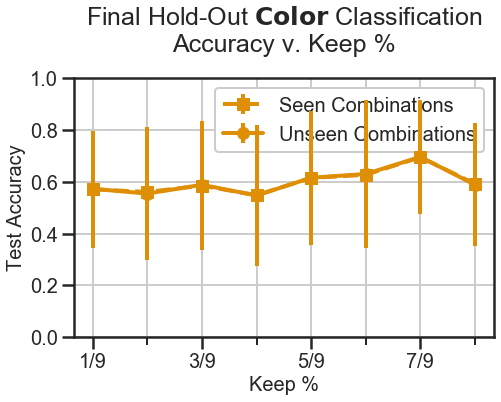

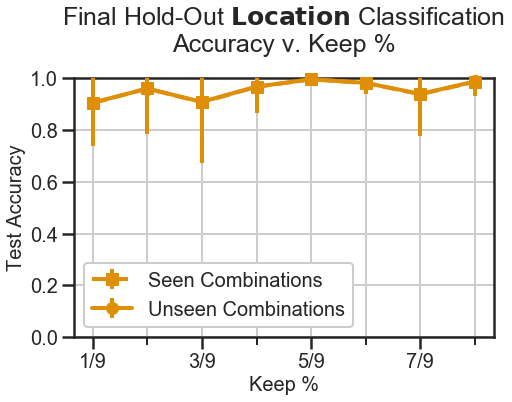

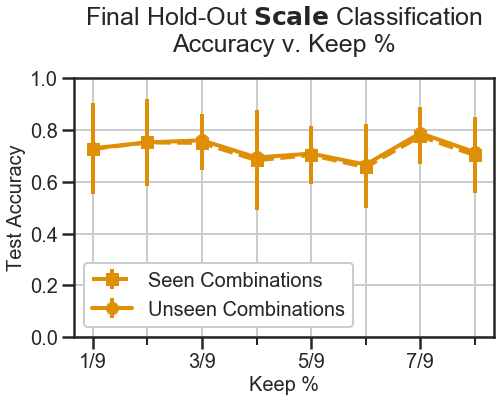

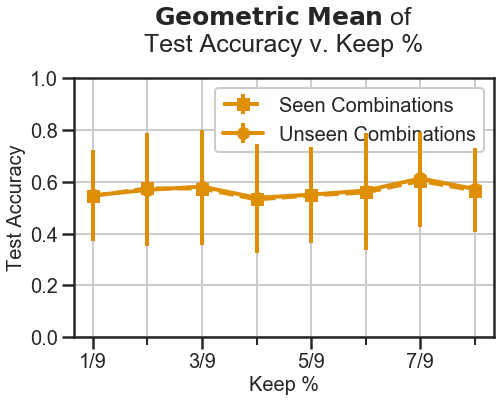

In [9]:
for input_name, experiment_name in [("col_loc_scale_mnist", "keep_pct_readout_4_task")]:
    for model_name in [\
#                        "simple_cnn",
                       "resnet", 
#                        "resnet_pretrained",
#                        "resnet_pretrained_embeddings",
#                        "resnet_no_pool",
                      ]:
        print("Task:", input_name, experiment_name)
        print("Architecture:", model_name)
        run_all(input_name, model_name, output_name, experiment_name)

In [10]:
def setup_fig(n, ylabel, title):
#     plt.clf()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_ylim(0, 1)
    ax.set_xlabel('Keep %')
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=25, y=1.08)

    # Set minor tick locations.
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
#     ax.xaxis.set_minor_locator(ticker.MultipleLocator(1/9))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1./n))
    # Set grid to use minor tick locations. 
    ax.grid(which = 'both')

    ax.set_yticks([x / 10. for x in range(0, 11, 2)])
    for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

    return fig, ax

model_names = \
[
#    "simple_cnn",
   "resnet", 
#    "resnet_pretrained", 
#    "resnet_pretrained_embeddings", 
#    "resnet_no_pool"
]
                 
task_to_labels = {
    "left_out_colored_mnist": ("Shape", "Color"),
    "left_out_varied_location_mnist": ("Shape", "Position")
 }

keep_pct_map = {
    "left_out_colored_mnist": ['1', '0.9', '0.8', '0.7', '0.6', '0.5', '0.4', '0.3', '0.2', '0.1'],
    "left_out_varied_location_mnist": ['1.0', '0.8888888888888888', '0.7777777777777778', '0.6666666666666666', '0.5555555555555556', '0.4444444444444444', '0.3333333333333333', '0.2222222222222222', '0.1111111111111111']
}
model_to_name = {"simple_cnn" : "2-Layer CNN",
               "resnet": "ResNet-18", 
               "resnet_pretrained": "ResNet-18 (CIFAR10 Pretrained)", 
               "resnet_pretrained_embeddings": "ResNet-18 (CIFAR10 Embeddings)", 
               "resnet_no_pool": "ResNet-18 (No Avg. Pooling)"
    
}
def combined_plot():
#     for input_name, experiment_name, n in [("left_out_colored_mnist", "keep_pct_readout_default_v2_weighted_save", 10),
#                                           ("left_out_varied_location_mnist", "keep_pct_readout_9_class_v2_weighted_save", 9)]:
      for input_name, experiment_name in [("left_out_colored_mnist", "keep_pct_readout_color_only"), 
                                    ("left_out_colored_mnist", "keep_pct_readout_shape_only"),
                                    ("left_out_varied_location_mnist", "keep_pct_readout_loc_only"),
                                   ("left_out_varied_location_mnist", "keep_pct_readout_shape_only")]:  
        shape_fig, shape_ax = setup_fig(n, "Test Accuracy", (r'Final Hold-Out $\bf {}$ Classification' + '\nAccuracy v. Keep %').format(task_to_labels[input_name][0]))
        color_fig, color_ax = setup_fig(n, "Test Accuracy", (r'Final Hold-Out $\bf {}$ Classification' + '\nAccuracy v. Keep %').format(task_to_labels[input_name][1]))
        geo_m_fig, geo_m_ax = setup_fig(n, "Geometric Mean", r'$\bf{Geometric}$ $\bf{Mean}$ of' + '\nTest Accuracy v. Keep %')

        for ax in [shape_ax, color_ax, geo_m_ax]:
            ax.set_xticks(np.array(keep_pct_map[input_name][:0:-2], dtype=float), minor=False)
            ax.set_xticklabels(np.array([str(i + 1) + "/" + str(len(keep_pct_map[input_name])) for i in range(0, len(keep_pct_map[input_name]), 2)]), minor=False)
            
        for model_name in model_names:
#             break
            timestamps = get_timestamps(input_name, model_name, output_name, experiment_name)
            _, test_results = get_results(timestamps)
            keep_pcts = get_keep_pcts(test_results)
            directory = get_directory(input_name, model_name, output_name, experiment_name)
                 
            left_out_final_num_accs_raw = np.array([[trial_test_results[keep_pct][-1]["left_out_num_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
            left_out_final_num_accs = np.mean(left_out_final_num_accs_raw, axis=0)
            left_out_final_num_accs_std = np.std(left_out_final_num_accs_raw, axis=0)
            left_out_final_col_accs_raw = np.array([[trial_test_results[keep_pct][-1]["left_out_col_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
            left_out_final_col_accs = np.mean(left_out_final_col_accs_raw, axis=0)
            left_out_final_col_accs_std = np.std(left_out_final_col_accs_raw, axis=0)

            left_out_geo_mean_acc_raw = np.sqrt(left_out_final_num_accs_raw * left_out_final_col_accs_raw)
            left_out_geo_mean_acc = np.mean(left_out_geo_mean_acc_raw, axis=0)
            left_out_geo_mean_acc_std = np.std(left_out_geo_mean_acc_raw, axis=0)
            
            shape_ax.errorbar([float(x) for x in keep_pcts[:0:-1]], left_out_final_num_accs[:0:-1], 
                              yerr=left_out_final_num_accs_std[:0:-1], zorder=10,
                              fmt='-o', clip_on=False, linewidth=4, color=color_map[model_name],
                             label=model_to_name[model_name])
            color_ax.errorbar([float(x) for x in keep_pcts[:0:-1]], left_out_final_col_accs[:0:-1], 
                              yerr=left_out_final_col_accs_std[:0:-1], zorder=10,
                              fmt='-o', clip_on=False, linewidth=4, color=color_map[model_name],
                             label=model_to_name[model_name])
            location_ax.errorbar([float(x) for x in keep_pcts[:0:-1]], left_out_final_loc_accs[:0:-1], 
                              yerr=left_out_final_loc_accs_std[:0:-1], zorder=10,
                              fmt='-o', clip_on=False, linewidth=4, color=color_map[model_name],
                             label=model_to_name[model_name])
            geo_m_ax.errorbar([float(x) for x in keep_pcts[:0:-1]], left_out_geo_mean_acc[:0:-1], 
                              yerr=left_out_geo_mean_acc_std[:0:-1], zorder=10,
                              fmt='-o', clip_on=False, linewidth=4, color=color_map[model_name],
                             label=model_to_name[model_name])
                 
#         shape_ax.legend(fontsize=16)
        shape_fig.subplots_adjust(top=0.8, bottom=0.2, left=0.17)
        shape_fig.savefig("shape-" + input_name + ".pdf")
        shape_fig.clf()
#         color_ax.legend(fontsize=16)
        color_fig.subplots_adjust(top=0.8, bottom=0.2, left=0.17)
        color_fig.savefig("color-" + input_name + ".pdf")
        color_fig.clf()
#         geo_m_ax.legend(fontsize=16, framealpha=1, loc='upper center', bbox_to_anchor=(0.5, -0.05),)
        geo_m_fig.subplots_adjust(top=0.8, bottom=0.2, left=0.17)
        geo_m_fig.savefig("geo_m-" + input_name + ".pdf")
        geo_m_fig.clf()
        plt.show()
                    
combined_plot()
# def combined_plot():
#     for input_name, experiment_name, n in [("left_out_varied_location_mnist", "keep_pct_readout_9_class_weighted_save", 9)]:
        
#         shape_fig, shape_ax = setup_fig(n, "Test Accuracy", (r'Final Hold-Out $\bf {}$ Classification' + '\nAccuracy v. Keep %').format(task_to_labels[input_name][0]))
#         color_fig, color_ax = setup_fig(n, "Test Accuracy", (r'Final Hold-Out $\bf {}$ Classification' + '\nAccuracy v. Keep %').format(task_to_labels[input_name][1]))
#         geo_m_fig, geo_m_ax = setup_fig(n, "Geometric Mean", r'$\bf{Geometric}$ $\bf{Mean}$ of' + '\nTest Accuracy v. Keep %')

#         for ax in [shape_ax, color_ax, geo_m_ax]:
#             ax.set_xticks(np.array(keep_pct_map[input_name][:0:-2], dtype=float), minor=False)
#             ax.set_xticklabels(np.array([str(i + 1) + "/" + str(len(keep_pct_map[input_name])) for i in range(0, len(keep_pct_map[input_name]), 2)]), minor=False)
            
#         for model_name in model_names:
# #             break
#             timestamps = get_timestamps(input_name, model_name, output_name, experiment_name)
#             _, test_results = get_results(timestamps)
#             keep_pcts = get_keep_pcts(test_results)
#             directory = get_directory(input_name, model_name, output_name, experiment_name)
                 
#             left_out_final_num_accs_raw = np.array([[trial_test_results[keep_pct][-1]["left_out_num_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
#             left_out_final_num_accs = np.mean(left_out_final_num_accs_raw, axis=0)
#             left_out_final_num_accs_std = np.std(left_out_final_num_accs_raw, axis=0)
#             left_out_final_col_accs_raw = np.array([[trial_test_results[keep_pct][-1]["left_out_col_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
#             left_out_final_col_accs = np.mean(left_out_final_col_accs_raw, axis=0)
#             left_out_final_col_accs_std = np.std(left_out_final_col_accs_raw, axis=0)

#             left_out_geo_mean_acc_raw = np.sqrt(left_out_final_num_accs_raw * left_out_final_col_accs_raw)
#             left_out_geo_mean_acc = np.mean(left_out_geo_mean_acc_raw, axis=0)
#             left_out_geo_mean_acc_std = np.std(left_out_geo_mean_acc_raw, axis=0)
            
#             print(keep_pcts[:0:-1])
#             shape_ax.errorbar([float(x) for x in keep_pcts[:0:-1]], left_out_final_num_accs[:0:-1], 
#                               yerr=left_out_final_num_accs_std[:0:-1], zorder=10,
#                               fmt='-o', clip_on=False, linewidth=4, color=color_map[model_name])
#             color_ax.errorbar([float(x) for x in keep_pcts[:0:-1]], left_out_final_col_accs[:0:-1], 
#                               yerr=left_out_final_col_accs_std[:0:-1], zorder=10,
#                               fmt='-o', clip_on=False, linewidth=4, color=color_map[model_name])
#             geo_m_ax.errorbar([float(x) for x in keep_pcts[:0:-1]], left_out_geo_mean_acc[:0:-1], 
#                               yerr=left_out_geo_mean_acc_std[:0:-1], zorder=10,
#                               fmt='-o', clip_on=False, linewidth=4, color=color_map[model_name])
                 
#     plt.show()
#     shape_fig.clf()
#     color_fig.clf()
#     geo_m_fig.clf()
                    
# combined_plot()

NameError: name 'n' is not defined